In [1]:
import numpy as np
from numpy import sin, cos, exp, sqrt, pi
from scipy.sparse import diags, spdiags, identity, kron
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
from matplotlib.ticker import LinearLocator
import matplotlib.gridspec as gridspec
from matplotlib.scale import LogScale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm

import os
from os import listdir
from os.path import isfile, isdir, join

import time
import h5py

In [2]:
def is_point_within_radius(point, target, radius):
    dist2 = (target[0] - point[0])**2 + (target[1] - point[1])**2
    if dist2 <= radius**2:
        return True
    return False

def grid_points_within_radius(center, radius, grid_steps):
    support = np.linspace(1/(grid_steps+1), 1 - 1/(grid_steps+1), grid_steps)
    points = []
    
    # The rows count down since the origin is now in the bottom left 
    # instead of the top left
    for c in range(grid_steps):
        for r in range(grid_steps):
            dist2 = (center[0] - support[c])**2 + (center[1] - support[-r-1])**2
            if dist2 < radius**2:
                points.append((c, grid_steps-r-1))
    return [grid_steps*c + r for (c, r) in points]

In [7]:
# import instance info
instance = "styblinski_tang"
instance_fn = lambda x1,x2: 1/78 * 0.5 * (x1**4 - 16*x1**2 + 5*x1 + x2**4 - 16*x2**2 + 5*x2)
instance_bounds = [-5, 5]
instance_global_min = [-2.9035, -2.9035]
gamma = 0.01
QHD_WFN_DIR = f"/Users/lengjiaqi/QHD_DATA/NonCVX-2d/{instance}/{instance}_QHD256_WFN"
ADB_WFN_DIR = f"/Users/lengjiaqi/QHD_DATA/NonCVX-2d/{instance}/{instance}_QAA128_T10.mat"

# experiment setup params
max_energy_level = 10
radius = 0.1
steps = 256
stepsize = 1/(steps+1)

In [8]:
# Step 1: Construct the kinetic and potential operators
L = instance_bounds[1]-instance_bounds[0]
dX = L / (steps + 1)
global_min_locs = [(instance_global_min[0] - instance_bounds[0])/L,
                   (instance_global_min[1] - instance_bounds[0])/L]
meshpoints = np.linspace(instance_bounds[0]+dX, instance_bounds[1]-dX, steps)
support = np.linspace(stepsize,1-stepsize,steps)

# Kinetic operator
e = np.ones(steps)
B = spdiags([e, -4*e, e], [-1, 0, 1], steps, steps)
A = spdiags([e, 0*e, e], [-1, 0, 1], steps, steps)
Id = identity(steps);
H_T = -0.5 / (stepsize**2) * (kron(Id,B) + kron(A,Id))

# Potential operator
original_V = np.empty(steps**2)
X = np.empty(steps**2)
Y = np.empty(steps**2)
Z = np.empty(steps**2)
for c in range(steps):
    x1 = meshpoints[c]
    for r in range(steps):
        x2 = meshpoints[-r-1]
        X[steps*c + steps-r-1] = support[c]
        Y[steps*c + steps-r-1] = support[-r-1]
        original_V[steps*c + steps-r-1] = instance_fn(x1, x2)

global_min_val = instance_fn(instance_global_min[0],instance_global_min[1])
normalized_V = (original_V - global_min_val) / L
H_U = diags(normalized_V, 0)

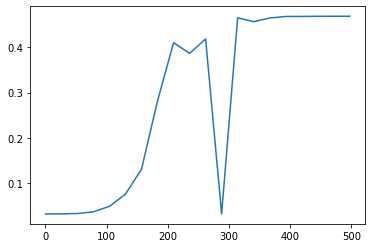

In [9]:
# Step 2: Retrieve QHD wave functions & probability
if isdir(QHD_WFN_DIR) == False:
    print(f"The data path for function {instance} is not found.")
else:
    wfn_files = os.listdir(QHD_WFN_DIR)
    wfn_files.sort()
    num_frames = len(wfn_files)
    qhd_prob_in_nbhd = np.zeros(num_frames)
    nbhd_idcs = grid_points_within_radius(global_min_locs, radius, steps)
    nbhd_locs = np.zeros((steps * steps,1))
    nbhd_locs[nbhd_idcs] = 1
    nbhd_locs = np.reshape(nbhd_locs, (steps,steps), order='F')

    for i in range(num_frames):
        psi = np.load(os.path.join(QHD_WFN_DIR, wfn_files[i]))
        prob_nbhd = (nbhd_locs * ((psi * psi.conj()).real)).sum()
        qhd_prob_in_nbhd[i] = prob_nbhd

# plot data
times = np.linspace(0, 497.5, num_frames)
plt.plot(times, qhd_prob_in_nbhd)

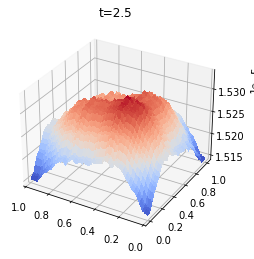

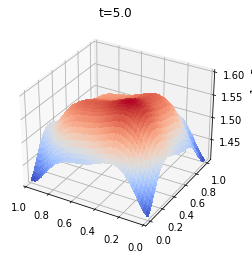

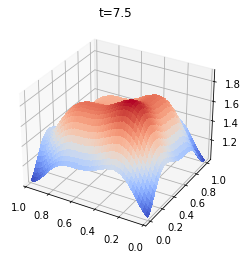

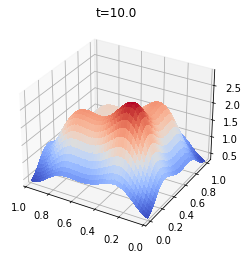

In [11]:
X = np.linspace(0,1-1/256,256)
Y = np.linspace(0,1-1/256,256)
X, Y = np.meshgrid(X,Y)


for frames in [1,2,3,4]:
    t = frames * 2.5
    wave_fn = np.load(os.path.join(QHD_WFN_DIR, wfn_files[frames]))
    density = (wave_fn * wave_fn.conj()).real
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.set_title(f"t={t}")
    ax.plot_surface(X, Y, density,
                   cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)
    ax.set_xlim(1,0)
    #plt.savefig(f"{instance}_wavepacket_t={t}.svg")

In [14]:
# nbhd means neighborhood
steps = int(np.sqrt(4096))  # Should be 64 for all of our data
nbhd_idcs = grid_points_within_radius(global_min_locs, radius, steps)
nbhd_locs = np.zeros((4096,1))
nbhd_locs[nbhd_idcs] = 1
nbhd_locs = np.reshape(nbhd_locs, (64,64), order='F')

adb_data = {}
adb_f = h5py.File(ADB_WFN_DIR, 'r')
for k, v in adb_f.items():
    adb_data[k] = np.array(adb_f.get(k))

adb_wfn = adb_data["wfn"].view(np.complex128)

adb_num_frames = len(adb_data["snapshot_times"][0])
adb_nbhd_prob = np.empty(adb_num_frames)
for idx in range(adb_num_frames):
    adb_frame = adb_wfn[:,idx]
    adb_nbhd_amps = adb_frame[nbhd_idcs]
    adb_prob = np.sum((adb_nbhd_amps * np.conj(adb_nbhd_amps)).real)
    adb_nbhd_prob[idx] = adb_prob

In [12]:
with open(f'{instance}_three_phase.npy', 'rb') as f:
    times = np.load(f)
    prob_spec = np.load(f)
    qhd_prob_in_nbhd = np.load(f)

In [13]:
with open(f'{instance}_energy_ratio.npy', 'rb') as f:
    time_range = np.load(f)
    E_ratio = np.load(f)
ratio_plot_idx = [i for i, val in enumerate(time_range < 125) if val]

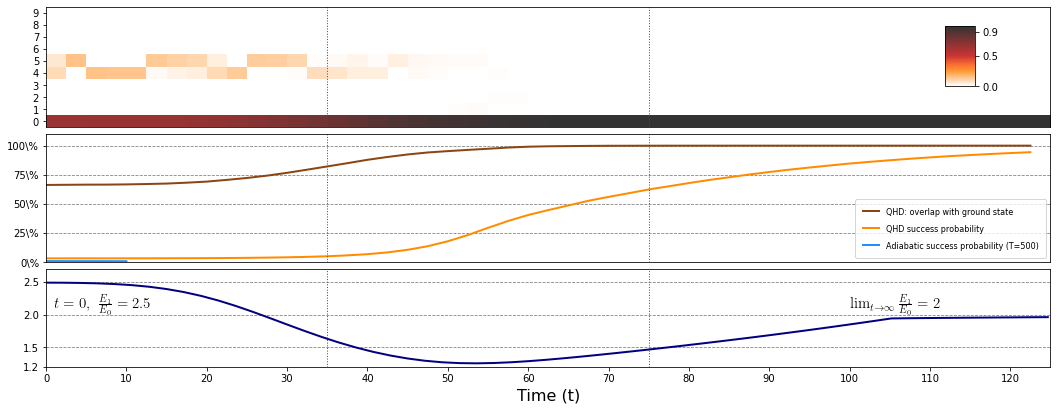

In [15]:
max_frame = 50
T_end = 2.5 * max_frame
T1 = 35
T2 = 75
ratio_0 = 0.8*18/120
ratio_1 = 0.85*18/120
ratio_2 = 0.65*18/120
cm = 1/2.54

# Adiabatic snapshot times
adb_snapshot_times = adb_data["snapshot_times"][0]
adb_plot_idx = [i for i, val in enumerate(adb_snapshot_times < T_end) if val]

fig, axs = plt.subplots(3, figsize=(18,6.75), gridspec_kw={'height_ratios': [0.85,0.9,0.7], 'width_ratios':[1]})

# Upper subplot
ax0 = axs[0]
#ax0.set_title("Probability Spectrum (Styblinski Tang)", fontsize=24)
im = ax0.imshow(prob_spec[:,0:max_frame],
                   alpha = 0.8,
                   extent=[0,125,0,10],
                   origin='lower',
                   interpolation='nearest',
                   cmap='gist_heat_r')
ax0.set_xlim([0,125])
ax0.set_xticks([])
yticks_loc = np.arange(1,11) - 0.5
ax0.set_yticks(yticks_loc, labels=np.arange(0,10))
ax0.axvline(x=T1, linewidth=1, color='r',linestyle='dotted')
ax0.axvline(x=T2, linewidth=1, color='r',linestyle='dotted')
ax0.set_aspect(125/10*ratio_0)
cbaxes = inset_axes(ax0,width="100%", height="100%",
                    loc='lower right',
                    bbox_to_anchor=(1-.1,.3,.03,.5),
                    bbox_transform=ax0.transAxes) 
plt.colorbar(im, cax=cbaxes, 
             ticks=[0.,0.5,0.9,1.0], 
             orientation='vertical')

# Middle subplot
ax1 = axs[1]
ax1.plot(times[0:max_frame],100 * prob_spec[0,0:max_frame], linewidth=2, color='saddlebrown', label="QHD: overlap with ground state")
ax1.plot(times[0:max_frame], 100 * qhd_prob_in_nbhd[0:max_frame], linewidth=2, color='darkorange', label="QHD success probability")
ax1.plot(adb_snapshot_times[adb_plot_idx], 100 * adb_nbhd_prob[adb_plot_idx], linewidth=2, color='dodgerblue', label="Adiabatic success probability (T=500)")
ax1.axvline(x=T1, linewidth=1, color='r',linestyle='dotted')
ax1.axvline(x=T2, linewidth=1, color='r',linestyle='dotted')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_xlim([0,125])
ax1.set_ylim([0,110])
ax1.set_xticks([])
ax1.set_yticks(np.arange(0,101, step=25))
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax1.set_axisbelow(True)
ax1.legend(loc="lower right",
           borderpad=1, 
           labelspacing=1, 
           fontsize=8,
           bbox_to_anchor=(1,0))
ax1.set_aspect(125/110*ratio_1)

# Lower subplot
ax2 = axs[2]
plt.rcParams['text.usetex'] = True
ax2.plot(time_range[ratio_plot_idx], E_ratio[ratio_plot_idx], linewidth=2, color='navy', label=r"$E_1/E_0$")
ax2.axvline(x=T1, linewidth=1, color='r',linestyle='dotted')
ax2.axvline(x=T2, linewidth=1, color='r',linestyle='dotted')
ax2.text(1, 2.1,r"$t = 0,~\frac{E_1}{E_0} = 2.5$", fontsize=15)
ax2.text(100, 2.1,r"$\lim_{t \to \infty}\frac{E_1}{E_0} = 2$", fontsize=15)
ax2.set_xlim([0,125])
ax2.set_ylim([1.2,2.7])
ax2.set_xticks(np.arange(0,126, step=10))
ax2.set_yticks([1.2,1.5,2.,2.5])
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax2.set_aspect(125/1.5*ratio_2)
ax2.set_xlabel('Time (t)', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"three_phase_{instance}.svg")

In [35]:
sns.reset_defaults

<function seaborn.rcmod.reset_defaults()>

/var/folders/5s/dkknlv856jz7y3hcb_13f9z00000gn/T/ipykernel_36738/1848043010.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, cax=cbaxes,


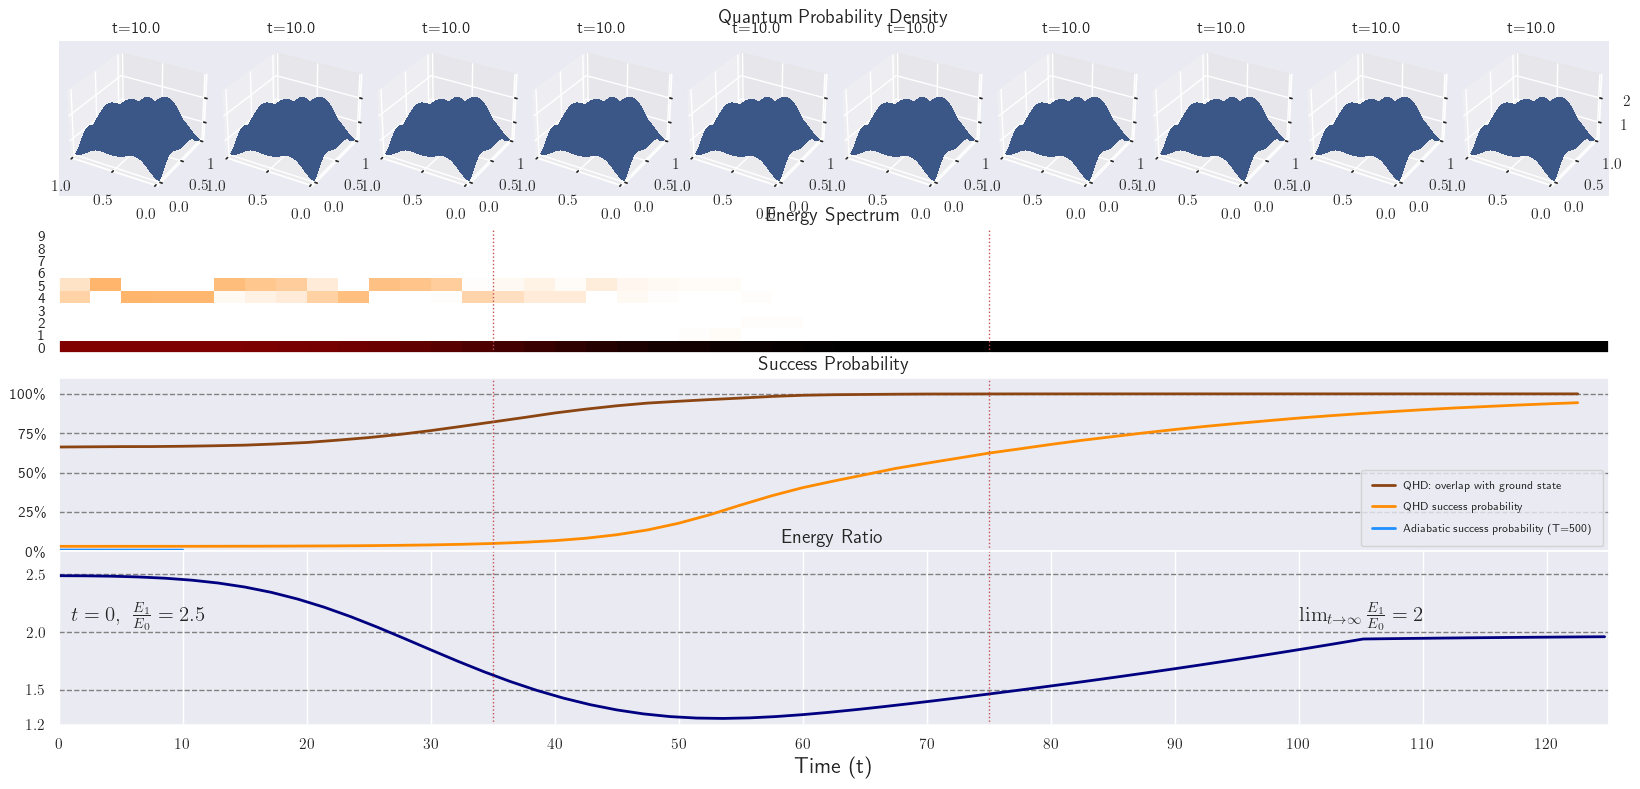

In [51]:
titles = ['Quantum Probability Density', 'Energy Spectrum', 'Success Probability', 'Energy Ratio']
SCATTER_SIZE = 0.5
TITLE_FONT = 14
TEXT_FONT = 12
CMAP = 'cool'

ratio_0 = 18/120
ratio_1 = 18/120
ratio_2 = 18/120

sns.set_theme()
fig = plt.figure(figsize=(20, 9))
gs = fig.add_gridspec(4, 10)

for row in range(4):
    ax = fig.add_subplot(gs[row, :])
    ax.set_title(titles[row], fontsize=TITLE_FONT)
    #ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if row == 0:
        ax.set_facecolor('white')
        for col in range(10):
            ax = fig.add_subplot(gs[0, col], projection='3d')
            ax.set_title(f"t={t}")
            ax.plot_surface(X, Y, density,
                   #cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)
            ax.set_xlim(1,0)
    
    if row == 1:
        im = ax.imshow(prob_spec[:,0:max_frame],
                   #alpha = 1,
                   extent=[0,125,0,10],
                   origin='lower',
                   interpolation='nearest',
                   cmap='gist_heat_r')
        ax.set_xlim([0,125])
        ax.grid(visible=None)
        ax.set_xticks([])
        yticks_loc = np.arange(1,11) - 0.5
        ax.set_yticks(yticks_loc, labels=np.arange(0,10))
        ax.axvline(x=T1, linewidth=1, color='r',linestyle='dotted')
        ax.axvline(x=T2, linewidth=1, color='r',linestyle='dotted')
        #ax.set_aspect(125/10*ratio_0)
        cbaxes = inset_axes(ax0,width="100%", height="100%",
                            loc='lower right',
                            bbox_to_anchor=(1-.1,.3,.03,.5),
                            bbox_transform=ax0.transAxes) 
        plt.colorbar(im, cax=cbaxes, 
                     ticks=[0.,0.5,0.9,1.0], 
                     orientation='vertical')
        
    if row == 2:
        ax.plot(times[0:max_frame],100 * prob_spec[0,0:max_frame], linewidth=2, color='saddlebrown', label="QHD: overlap with ground state")
        ax.plot(times[0:max_frame], 100 * qhd_prob_in_nbhd[0:max_frame], linewidth=2, color='darkorange', label="QHD success probability")
        ax.plot(adb_snapshot_times[adb_plot_idx], 100 * adb_nbhd_prob[adb_plot_idx], linewidth=2, color='dodgerblue', label="Adiabatic success probability (T=500)")
        ax.axvline(x=T1, linewidth=1, color='r',linestyle='dotted')
        ax.axvline(x=T2, linewidth=1, color='r',linestyle='dotted')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_xlim([0,125])
        ax.set_ylim([0,110])
        ax.set_xticks([])
        ax.set_yticks(np.arange(0,101, step=25))
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.set_axisbelow(True)
        ax.legend(loc="lower right",
                   borderpad=1, 
                   labelspacing=1, 
                   fontsize=8,
                   bbox_to_anchor=(1,0))
        #ax.set_aspect(125/110*ratio_1)
    
    if row == 3:
        plt.rcParams['text.usetex'] = True
        ax.plot(time_range[ratio_plot_idx], E_ratio[ratio_plot_idx], linewidth=2, color='navy', label=r"$E_1/E_0$")
        ax.axvline(x=T1, linewidth=1, color='r',linestyle='dotted')
        ax.axvline(x=T2, linewidth=1, color='r',linestyle='dotted')
        ax.text(1, 2.1,r"$t = 0,~\frac{E_1}{E_0} = 2.5$", fontsize=15)
        ax.text(100, 2.1,r"$\lim_{t \to \infty}\frac{E_1}{E_0} = 2$", fontsize=15)
        ax.set_xlim([0,125])
        ax.set_ylim([1.2,2.7])
        ax.set_xticks(np.arange(0,126, step=10))
        ax.set_yticks([1.2,1.5,2.,2.5])
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        #ax.set_aspect(125/1.5*ratio_2)
        ax.set_xlabel('Time (t)', fontsize=16)
        plt.subplots_adjust(wspace=0, hspace=0)